In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Cargar el dataset
csv_ruta = 'data_imagenes.csv'
df_datos = pd.read_csv(csv_ruta)


# Verificar las rutas de las imágenes
ruta_imagen = 'imagenes_ecg/..'
df_datos["image_path"] = df_datos["image_path"].apply(lambda x: os.path.abspath(os.path.join(ruta_imagen, x)))

# Verificar el balance de clases
df_datos['image_path'] = df_datos['image_path'].astype(str)
df_datos['label'] = df_datos['label'].astype(str)
# Obtener el número de clases
num_clases = df_datos['label'].nunique()

# Preprocesamiento de imágenes con un aumento de datos moderado
datosgen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train = datosgen.flow_from_dataframe(dataframe=df_datos, 
                                     x_col='image_path', 
                                     y_col='label',
                                     target_size=(224, 224), class_mode='categorical',
                                     batch_size=32, subset='training')

val = datosgen.flow_from_dataframe(dataframe=df_datos, 
                                   x_col='image_path',
                                   y_col='label',
                                   target_size=(224, 224), 
                                   class_mode='categorical',
                                   batch_size=32, subset='validation')

Found 12522 validated image filenames belonging to 4 classes.
Found 3130 validated image filenames belonging to 4 classes.


In [3]:
# Cargar el modelo base VGG16
modelo_base = VGG16(include_top=False, input_shape=(224, 224, 3))

# Descongelar menos capas para evitar el sobreajuste
modelo_base.trainable = True
for layer in modelo_base.layers[:18]:  # Aumentamos a las primeras 18 capas congeladas
    layer.trainable = False

# Construir el modelo
x = Flatten()(modelo_base.output)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)  # Aumentamos el dropout para mayor regularización
x = Dense(num_clases, activation='softmax')(x)

modelo = Model(inputs=modelo_base.input, outputs=x)

# Compilar el modelo con un learning rate más bajo
modelo.compile(
    optimizer=Adam(learning_rate=0.00001),  # Reducimos el learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [4]:
# Callbacks: EarlyStopping y ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)  # Mayor paciencia

# Entrenar el modelo
entrenamiento = modelo.fit(train, validation_data=val, epochs=30, callbacks=[early_stopping, reduce_lr])

c:\Users\Julito\OneDrive\Documentos\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
392/392 ━━━━━━━━━━━━━━━━━━━━ 1690s 4s/step - accuracy: 0.3481 - loss: 2.8905 - val_accuracy: 0.5118 - val_loss: 2.2042 - learning_rate: 1.0000e-05
Epoch 2/30
392/392 ━━━━━━━━━━━━━━━━━━━━ 1665s 4s/step - accuracy: 0.4895 - loss: 2.1419 - val_accuracy: 0.6840 - val_loss: 1.6345 - learning_rate: 1.0000e-05
Epoch 3/30
392/392 ━━━━━━━━━━━━━━━━━━━━ 1656s 4s/step - accuracy: 0.5717 - loss: 1.8439 - val_accuracy: 0.7288 - val_loss: 1.5000 - learning_rate: 1.0000e-05
Epoch 4/30
392/392 ━━━━━━━━━━━━━━━━━━━━ 1657s 4s/step - accuracy: 0.5920 - loss: 1.7225 - val_accuracy: 0.7441 - val_loss: 1.3818 - learning_rate: 1.0000e-05
Epoch 5/30
392/392 ━━━━━━━━━━━━━━━━━━━━ 1655s 4s/step - accuracy: 0.6402 - loss: 1.5806 - val_accuracy: 0.2834 - val_loss: 2.6770 - learning_rate: 1.0000e-05
Epoch 6/30
392/392 ━━━━━━━━━━━━━━━━━━━━ 1676s 4s/step - accuracy: 0.6573 - loss: 1.5030 - val_accuracy: 0.8073 - val_loss: 1.1975 - learning_rate: 1.0000e-05
Epoch 7/30
392/392 ━━━━━━━━━━━━━━━━━━━━ 1664s 4s/ste

In [5]:
#modelo.save('modelo_vgg16_ecg.h5')
modelo.save('modelo_pre_entrenado_ecg.keras')

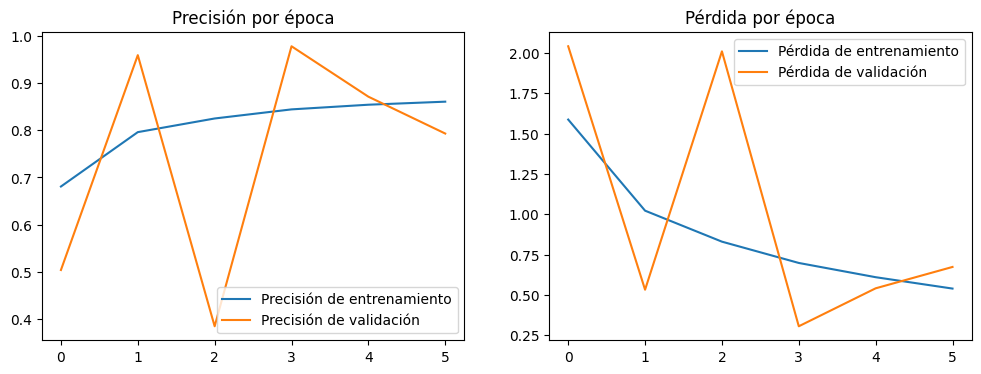

In [9]:
# Graficar la precisión y la pérdida
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(entrenamiento.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(entrenamiento.history['val_accuracy'], label='Precisión de validación')
plt.legend()
plt.title('Precisión por época')

plt.subplot(1, 2, 2)
plt.plot(entrenamiento.history['loss'], label='Pérdida de entrenamiento')
plt.plot(entrenamiento.history['val_loss'], label='Pérdida de validación')
plt.legend()
plt.title('Pérdida por época')

plt.show()